# 0 Utils

In [1]:
import os
import numpy as np
import seaborn as sb
%matplotlib inline
sb.set()
import matplotlib.pyplot as plt
import pandas as pd
import shap

N_JOBS = 6
RANDOM_STATE = 42

In [72]:
import warnings
warnings.filterwarnings('ignore')

## Experiment Setting 

In [2]:
import time
start_time = time.time()


In [3]:
predictors_set = dict()

no_is =['actividad', 'loc_comuna', 'loc_provincia', 'loc_region', 'is_descuento', 'is_presencial',
       'mean_cot_bod', 'mean_cot_depto', 'mean_cot_esta', 'mean_cot_estu', 'is_remoto',
       'nro_cot_bod', 'nro_cot_depto', 'valid_rut',
       'nro_cot_esta', 'nro_cot_estu', 'nro_proyectos','is_recontacto',
       'sexo', 'tipo_cliente', 'medio_inicial',  
        'Altos del Valle', 
        'Edificio Urban 1470',
       'San Andres Del Valle', 
        'Edificio Mil610', 
        'Edificio Junge'
       ]

predictors_set ['no_is'] = no_is

base = ['is_apellido1', 'is_appelido2', 'is_celular',
       'is_direccion', 'is_fnac', 'is_nombre', 'is_nombrecompleto',
       'is_nrofam', 'is_profesion', 'is_telefono',
       'loc_comuna', 'loc_provincia', 'loc_region',
       'mean_cot_bod', 'mean_cot_depto', 'mean_cot_esta', 'mean_cot_estu',
       'nro_cot_bod', 'nro_cot_depto',
       'nro_cot_esta', 'nro_cot_estu', 'nro_proyectos',
       'sexo', 'tipo_cliente', 
        'Altos del Valle', 
#         'Edificio Urban 1470',
       'San Andres Del Valle', 
        'Edificio Mil610', 
        'Edificio Junge']

print(len(base))
predictors_set ['base'] = base

base_profesion = base[0:]
base_profesion.append('profesion')
print(len(base_profesion))
predictors_set ['base_profesion'] = base_profesion

base_minusisprofesion = base_profesion[0:]
base_minusisprofesion.remove('is_profesion')
print(len(base_minusisprofesion))
predictors_set ['base_minusisprofesion'] = base_minusisprofesion

base_medini_isrec = base_profesion[0:]
base_medini_isrec.append('medio_inicial')
base_medini_isrec.append('is_recontacto')
print(len(base_medini_isrec))
predictors_set ['base_medini_isrec'] = base_medini_isrec


28
29
28
31


In [4]:
# dataset, base nro 2
dataset_nro = 7
experiment_nro = 1
# 'All Proyects', 'Altos del Valle', 'Edificio Urban 1470','San Andres Del Valle', 'Edificio Mil610', 'Edificio Junge'
proyecto_select = 'All Proyects'

# base, base_profesion, base_minusisprofesion, base_medini_isrec
use_predictors = 'no_is'
# experimento 2 y 4 va con True
no_nulls = False
sesgo = False

# 1 Load Dataset

In [5]:
# nombre experimento
exp_name = "{} {} exp".format(proyecto_select, use_predictors)
# eleccion dataset
dataset = 'personas_cotizacion{}.csv'.format(dataset_nro)

# DS_NAME = dataset.split('.')[0]
DS_NAME = exp_name

folder = '..\\results\\model_results\\{}'.format(DS_NAME)

if not os.path.exists(folder):
    os.mkdir(folder)


personas = pd.read_csv('..\\..\\Datos\\experiments\\{}'.format(dataset), encoding = "ISO-8859-1")

readme = dict()
readme['experiment_name'] = DS_NAME
readme['experiment_dataset'] = dataset

print(personas.shape)
readme['personas_shape'] = personas.shape
# personas.head(2)

print(personas.columns)
readme['personas_columns'] = personas.columns.tolist()

(6183, 42)
Index(['Unnamed: 0', 'actividad', 'compra', 'is_apellido1', 'is_apellido2',
       'is_celular', 'is_descuento', 'is_direccion', 'is_fnac', 'is_nombre',
       'is_nombrecompleto', 'is_nrofam', 'is_presencial', 'is_profesion',
       'is_recontacto', 'is_remoto', 'is_telefono', 'loc_comuna',
       'loc_provincia', 'loc_region', 'max_rango_edad', 'mean_cot_bod',
       'mean_cot_depto', 'mean_cot_esta', 'mean_cot_estu', 'medio_inicial',
       'negocio', 'nro_cot_bod', 'nro_cot_depto', 'nro_cot_esta',
       'nro_cot_estu', 'nro_proyectos', 'profesion', 'rut', 'sexo',
       'tipo_cliente', 'valid_rut', 'Altos del Valle', 'Edificio Urban 1470',
       'San Andres Del Valle', 'Edificio Mil610', 'Edificio Junge'],
      dtype='object')


In [6]:
personas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6183 entries, 0 to 6182
Data columns (total 42 columns):
Unnamed: 0              6183 non-null int64
actividad               6183 non-null object
compra                  6183 non-null bool
is_apellido1            6183 non-null bool
is_apellido2            6183 non-null bool
is_celular              6183 non-null bool
is_descuento            6183 non-null bool
is_direccion            6183 non-null bool
is_fnac                 6183 non-null bool
is_nombre               6183 non-null bool
is_nombrecompleto       6183 non-null bool
is_nrofam               6183 non-null bool
is_presencial           6183 non-null bool
is_profesion            6183 non-null bool
is_recontacto           6183 non-null bool
is_remoto               6183 non-null bool
is_telefono             6183 non-null bool
loc_comuna              6183 non-null object
loc_provincia           6183 non-null object
loc_region              6183 non-null object
max_rango_edad          

In [7]:
personas['loc_comuna'] = personas['loc_comuna'].astype('category')
personas['loc_provincia'] = personas['loc_provincia'].astype('category')
personas['loc_region'] = personas['loc_region'].astype('category')
personas['tipo_cliente'] = personas['tipo_cliente'].astype('category')
personas['sexo'] = personas['sexo'].astype('category')
personas.profesion.fillna('sin informacion', inplace=True)
personas['profesion'] = personas['profesion'].astype('category')
personas['medio_inicial'] = personas['medio_inicial'].astype('category')

In [8]:
personas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6183 entries, 0 to 6182
Data columns (total 42 columns):
Unnamed: 0              6183 non-null int64
actividad               6183 non-null object
compra                  6183 non-null bool
is_apellido1            6183 non-null bool
is_apellido2            6183 non-null bool
is_celular              6183 non-null bool
is_descuento            6183 non-null bool
is_direccion            6183 non-null bool
is_fnac                 6183 non-null bool
is_nombre               6183 non-null bool
is_nombrecompleto       6183 non-null bool
is_nrofam               6183 non-null bool
is_presencial           6183 non-null bool
is_profesion            6183 non-null bool
is_recontacto           6183 non-null bool
is_remoto               6183 non-null bool
is_telefono             6183 non-null bool
loc_comuna              6183 non-null category
loc_provincia           6183 non-null category
loc_region              6183 non-null category
max_rango_edad    

In [9]:
# personas['negocio'] = ['negocio' if x == True else 'no negocio' for x in personas.negocio]
# personas.negocio.unique()

In [10]:
# tab_info=pd.DataFrame(personas.dtypes).T.rename(index={0:'column type'})
# tab_info=tab_info.append(pd.DataFrame(personas.isnull().sum()).T.rename(index={0:'null values (nb)'}))
# tab_info=tab_info.append(pd.DataFrame(personas.isnull().sum()/personas.shape[0]*100).T.rename(index={0:'null values (%)'}))
# display(tab_info)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C0655AF390>,
      dtype=object)

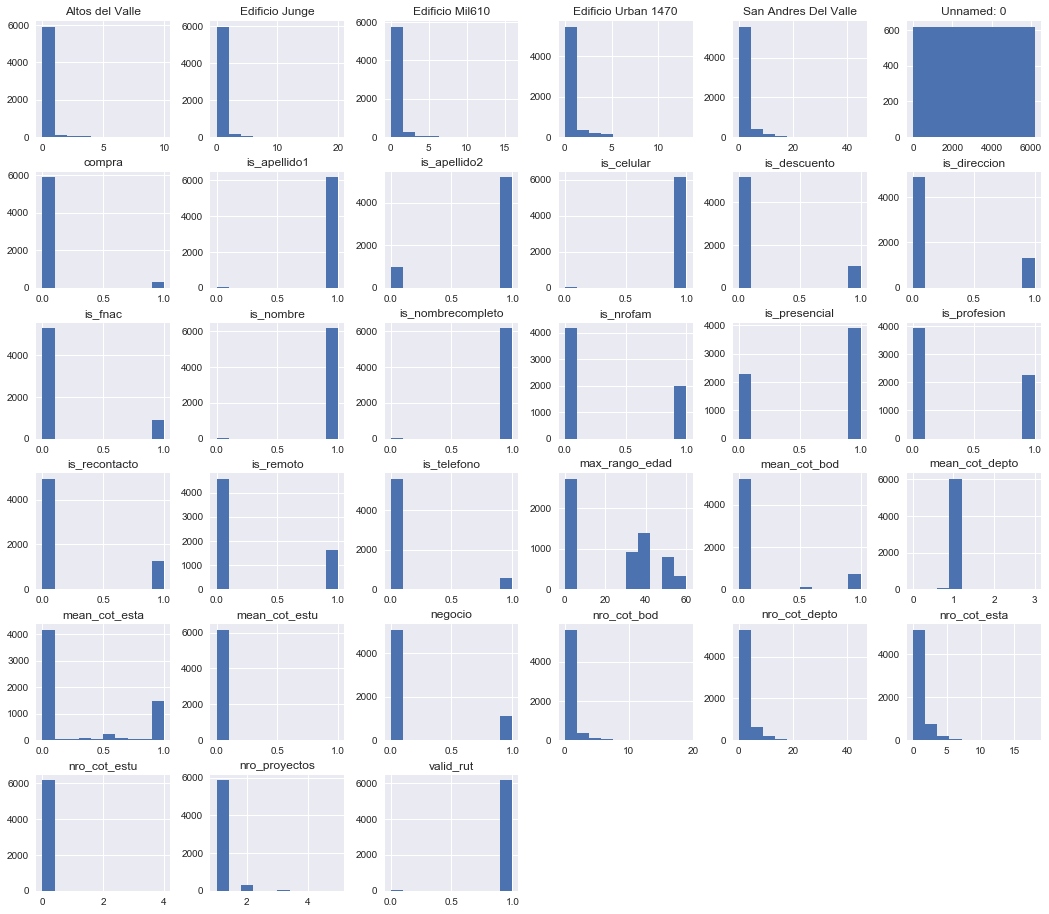

In [11]:
personas.hist(figsize=(18,16))

In [12]:
# Ajustes especificos experimento
# Para E5D5, E6D5 #########################################
if proyecto_select != 'All Proyects':
    mask = (personas[proyecto_select] > 0)
    personas = personas[mask]
    print(personas[mask].shape)
    personas[mask]
###########################################################

predictors = predictors_set[use_predictors]

# print(personas[personas['profesion']=='sin informacion'].shape)
# print(personas.profesion.nunique())
# print(personas.is_profesion.unique())

# En que experimento use esto? E8D6 y E28D6
# Se usa en los experimentos de data set limpio para evaluar con las personas que si entregaron la profesion
# personas.replace(['sin informacion'], np.nan, inplace=True)
# personas.dropna(inplace=True)
if no_nulls:
    personas.replace(['sin informacion'], np.nan, inplace=True)
    personas.dropna(inplace=True)

In [13]:
# Ready Data Set
p_negocio = personas.negocio # Target
# personas = personas.drop(drop_columns, axis=1) # Predictors
personas = personas[predictors]

print(p_negocio.shape)
print(personas.shape)
readme['personas_after_drop_columns'] = personas.columns

print(personas.shape)
readme['personas_predictors_shape'] = personas.shape
readme['personas_predictors'] = personas.columns


personas = pd.get_dummies(personas)
readme['personas_dummies_shape'] = personas.shape

# personas.describe()

(6183,)
(6183, 26)
(6183, 26)


## Correlacion 

In [14]:
# from scipy.stats.stats import pearsonr, spearmanr, kendalltau
# corr_p = personas.corr(method='pearson')

# import seaborn as sns
# f = plt.figure(figsize=(40,20))
# g = sns.heatmap(corr_p, annot=True).get_figure()
# g.savefig('..\\img\\time_series_corr.png')

In [15]:
# from sklearn.feature_selection import VarianceThreshold
# vt = VarianceThreshold()
# personas_vt = vt.fit_transform(personas)

In [16]:
# print(personas_vt.shape)
# print(vt.variances_)

# 3 Supervised Learning: Classification

## 3.1 Libraries

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

## 3.2 Check the Dataset

In [18]:
print("Tamaño Total: ", personas.shape)
print("Personas que hicieron Negocio: ", p_negocio[p_negocio == True].shape)
print("Personas que no Hicieorn Negocio: ", p_negocio[p_negocio == False].shape)
readme['personas_negocio'] = p_negocio[p_negocio == True].shape
readme['personas_nonegocio'] = p_negocio[p_negocio == False].shape

Tamaño Total:  (6183, 58)
Personas que hicieron Negocio:  (1100,)
Personas que no Hicieorn Negocio:  (5083,)


In [19]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2

# transformer = SelectKBest(score_func=chi2,k=10)
# Xt_chi2 = transformer.fit_transform(X,y)
# print(Xt_chi2.shape)
# print(transformer.scores_)

## 3.3 Train & Test

In [20]:
X = personas
y = p_negocio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
readme['x_train_shape'] = X_train.shape
readme['y_train_shape'] = y_train.shape
readme['x_test_shape'] = X_test.shape
readme['y_test_shape'] = y_test.shape

(4328, 58) (1855, 58) (4328,) (1855,)


## 3.4 Help Functions

In [21]:
readme['model'] = dict()

In [22]:
roc_curves_to_plot= dict()

In [23]:
roc_curves_to_plot[DS_NAME]= dict()

In [77]:
import json
def save_readme():    
    exDict = {'readme': readme}
    with open('..\\results\\model_results\\{}\\readme_{}.txt'.format(DS_NAME, DS_NAME), 'w') as file:
        file.write(str(exDict))

def plot_all_auc_values():
        
    d = dict()
    for key in roc_curves_to_plot[DS_NAME]:
        d[key] = roc_curves_to_plot[DS_NAME][key]['auc']
    
    s = [(k, d[k]) for k in sorted(d, key=d.get, reverse=True)]
    
    x_model = [x[0] for x in s]
    x_value = [x[1] for x in s]
    
    x = np.arange(len(roc_curves_to_plot[DS_NAME].keys()))
    
    plt.title('{} AUC Models'.format(DS_NAME))
    plt.xlabel('Models')
    plt.ylabel('AUC')
    plt.bar(x, x_value)
    plt.xticks(x, x_model)
    plt.savefig('..\\results\\model_results\\{}\\auc_models.png'.format(DS_NAME,DS_NAME), dpi=300)
    plt.show()

def plot_all_roc_curves():
    
    f = plt.figure(figsize=(12,8))
    plt.plot([0, 1], [0, 1], 'k--')
    
    for key in roc_curves_to_plot[DS_NAME]:
        plt.plot(roc_curves_to_plot[DS_NAME][key]['fpr'], roc_curves_to_plot[DS_NAME][key]['tpr']) #fpr and tpr
    
    legends = ['random choice']
    legends.extend(roc_curves_to_plot[DS_NAME].keys())
    plt.legend(legends)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Models ROC Curve'.format(DS_NAME))
    plt.savefig('..\\results\\model_results\\{}\\roc_curve_all.png'.format(DS_NAME, MODEL), dpi=300)
    plt.show()

# Import necessary modules
def roc_curve_plot(model, X_test, y_test):
    
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = model.predict_proba(X_test)[:,1]

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, treshold = roc_curve(y_test, y_pred_prob)
    
    roc_curves_to_plot[DS_NAME][MODEL] = dict()
    roc_curves_to_plot[DS_NAME][MODEL]['fpr'] = fpr
    roc_curves_to_plot[DS_NAME][MODEL]['tpr'] = tpr
    roc_curves_to_plot[DS_NAME][MODEL]['auc'] = roc_auc_score(y_test, y_pred_prob)
    
    print('AUC Score:', roc_curves_to_plot[DS_NAME][MODEL]['auc'])
    
    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} {} ROC Curve'.format(DS_NAME, MODEL))
    plt.savefig('..\\results\\model_results\\{}\\{}_roc_curve.png'.format(DS_NAME, MODEL), dpi=300)
    plt.show()

def plot_confusion_matrix(model, X, y, y_pred):
    print(confusion_matrix(y, y_pred))
    readme['model'][MODEL]['conf_matrix'] = confusion_matrix(y, y_pred)
    
    print(classification_report(y, y_pred))
    readme['model'][MODEL]['cla_report'] = classification_report(y, y_pred)
    
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(5,5))
    
    sb.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    title_plt = "{} {} Conf. Matrix".format(DS_NAME, MODEL)
    plt.title(title_plt, size=10);
    plt.savefig('..\\results\\model_results\\{}\\{}_confusion_matrix.png'.format(DS_NAME, MODEL), dpi=300)
    plt.show()

def plot_importance_graph(model):
    features = personas.columns
    
    feature_importance = model.best_estimator_.feature_importances_ 
    fig = plt.figure(figsize=(20, 18))
    ax = fig.add_subplot(111)

    df_f = pd.DataFrame(feature_importance, columns=["importance"])
    df_f["labels"] = features
    df_f.sort_values("importance", inplace=True, ascending=False)
    display(df_f.head(5))

    index = np.arange(len(feature_importance[:20]))
    bar_width = 0.5
    rects = plt.barh(index[:20] , df_f["importance"][:20], bar_width, alpha=0.4, color='b', label='Main')
    plt.yticks(index, df_f["labels"])
    plt.title("{} {} Feature Importance".format(DS_NAME, MODEL))
    plt.savefig('..\\results\\model_results\\{}\\{}_importance.png'.format(DS_NAME, MODEL), dpi=300)
    plt.show()

def grid_results(grid, plot_roc_curve=True):
    best_model = grid.best_estimator_
   
    readme['model'][MODEL]['name'] = MODEL
    readme['model'][MODEL]['best_estimator'] = grid.best_estimator_
    readme['model'][MODEL]['best_score'] = grid.best_score_
    
    print("Best score is {}".format(grid.best_score_))
    
    y_pred = best_model.predict(X_test)
    
    # Confusion Matrix
    print()
    plot_confusion_matrix(best_model, X_test, y_test, y_pred)
    
    #Update Exec Time
    readme['time_exec'] = time.time() - start_time
    
    #Update README
    save_readme()
    
    #ROC Curve
    if plot_roc_curve:
        roc_curve_plot(best_model, X_test, y_test)

## 3.5 Models

In [25]:
to_profit_curve = dict()

# GRID Unbalanced RandomForest

Best estimator is RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=12, max_features=26, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Tuned Decision Tree Parameters: {'min_samples_leaf': 6, 'max_features': 26, 'max_depth': 12, 'criterion': 'entropy'}
Best score is 0.8670548277535177
Best score is 0.8670548277535177

[[1460   37]
 [ 178  180]]
             precision    recall  f1-score   support

      False       0.89      0.98      0.93      1497
       True       0.83      0.50      0.63       358

avg / total       0.88      0.88      0.87      1855



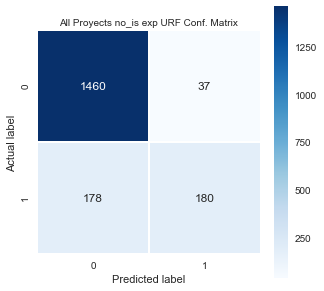

AUC Score: 0.9223661475651489


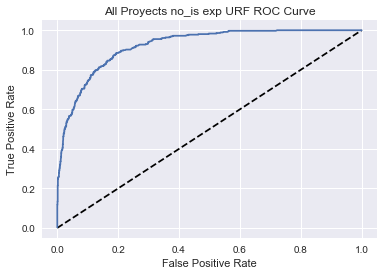

,importance,labels
16,0.227122,San Andres Del Valle
8,0.179650,nro_cot_depto
23,0.076301,actividad_Profesional
13,0.071182,is_recontacto
1,0.032714,is_presencial


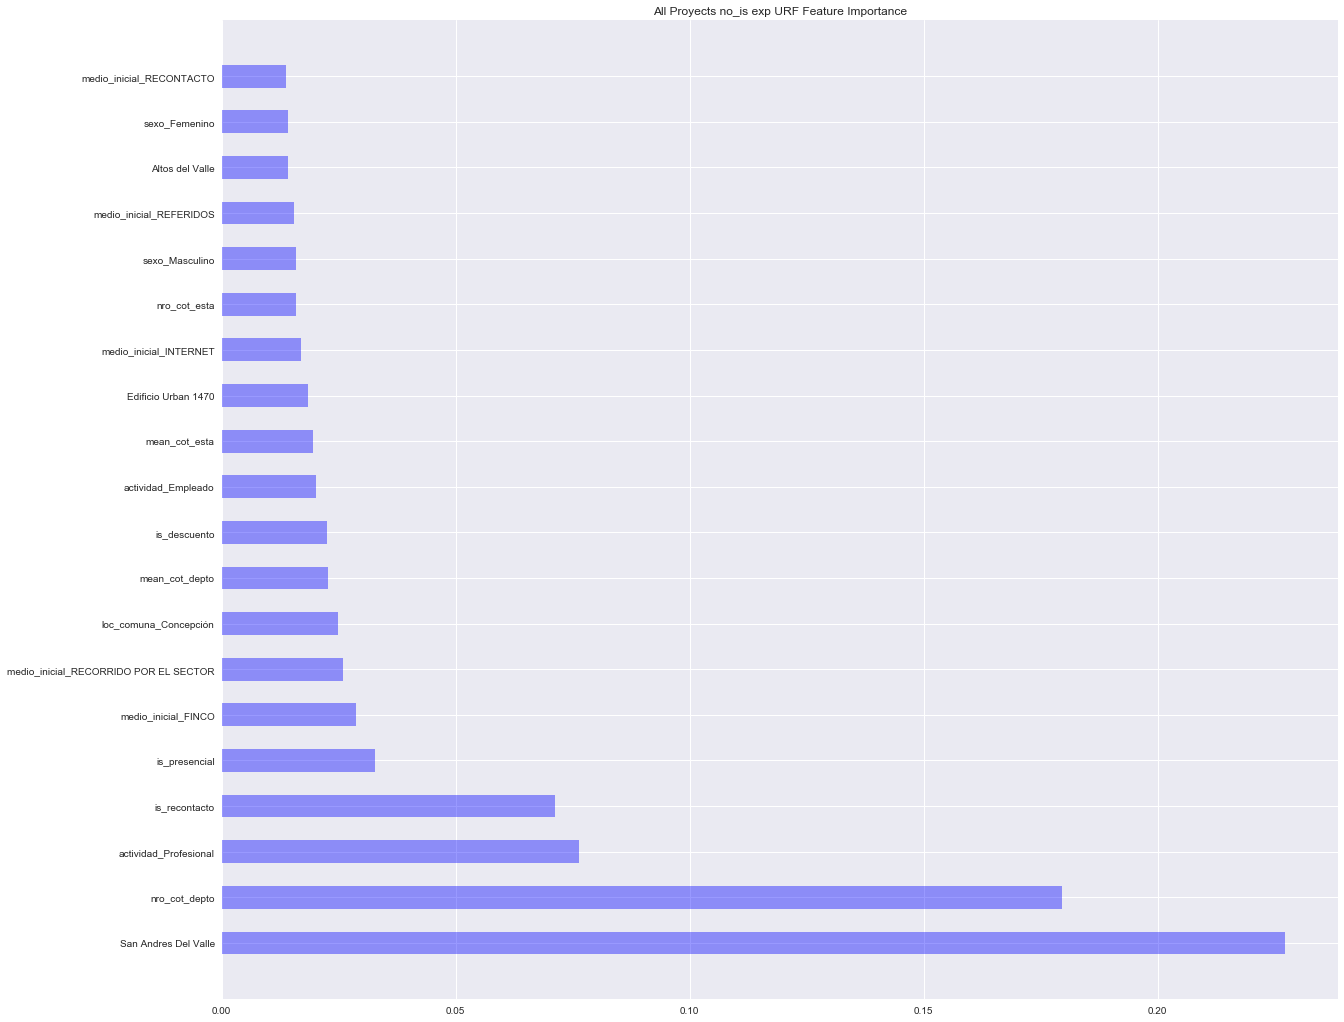

In [78]:
# Setup the parameters and distributions to sample from: param_dist
MODEL = 'URF'
readme['model'][MODEL] = dict()

param_grid = {
    "max_depth": randint(1,30),
    "max_features":randint(1,40),
    "min_samples_leaf": randint(1,20),
    "criterion": ["gini", "entropy"],
    "min_samples_split": randint(2,20),
    "n_estimators":[20,30,40,50,60,70,80,90,100],
    "bootstrap": [True, False],
}

param_grid = {"max_depth": list(range(1,30)),
              'max_features': ['auto', 'sqrt', 'log2'],
#               "max_features":range(1,40),
              "min_samples_split": list(range(2,30)),
              "min_samples_leaf": list(range(1,20)),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
             "n_estimators":list(range(20,100,10)),
#               "class_weight":[None,'balanced' ],
}

param_dist = {
    "max_depth": range(1,20),
    "max_features":range(1,30),
    "min_samples_leaf": range(1,10),
    "criterion": ["gini", "entropy"]
}

# Instantiate a Decision Tree classifier: tree
rf = RandomForestClassifier()

# Stratified
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Instantiate the RandomizedSearchCV object: tree_cv
grid_urf = RandomizedSearchCV(rf, param_dist, cv=kf, n_jobs=N_JOBS, n_iter=300)
# rf_cv = GridSearchCV(rf, param_grid, cv=kf, n_jobs=N_JOBS)

# Fit it to the data
grid_urf.fit(X,y)

# Predict
# y_pred = rf_cv.predict(X_test)

# Print the tuned parameters and score
print("Best estimator is {}".format(grid_urf.best_estimator_))
print("Tuned Decision Tree Parameters: {}".format(grid_urf.best_params_))
print("Best score is {}".format(grid_urf.best_score_))

grid_results(grid_urf)
plot_importance_graph(grid_urf)

# Unbalanced RandomForest

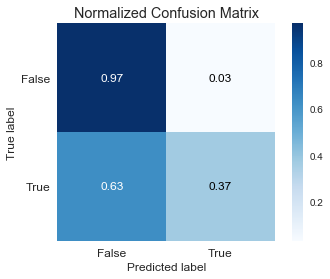

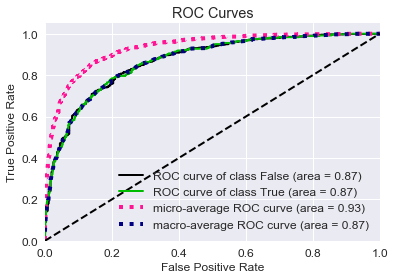

In [80]:
urf_clf = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=26,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
            oob_score=False, random_state=RANDOM_STATE, verbose=0,
            warm_start=False)

from sklearn.model_selection import cross_val_predict
predictions = cross_val_predict(urf_clf, X, y)

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)
plt.show()

urf_clf.fit(X_train, y_train)
y_probas = urf_clf.predict_proba(X_test)

# print(roc_auc_score(y_test, y_probas))
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()

# Balanced RandomForest

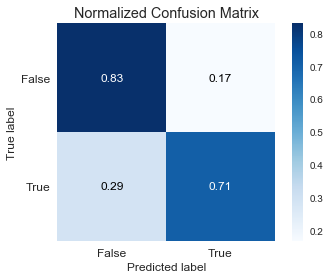

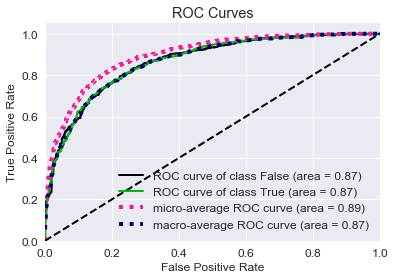

In [81]:
brf_clf = RandomForestClassifier(bootstrap=False, class_weight='balanced', criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=26,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
            oob_score=False, random_state=RANDOM_STATE, verbose=0,
            warm_start=False)

from sklearn.model_selection import cross_val_predict
predictions = cross_val_predict(brf_clf, X, y)

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)
plt.show()

brf_clf.fit(X_train, y_train)
y_probas = brf_clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()

# GRID RandomForest Balanced

Best Params:  {'min_samples_leaf': 7, 'max_features': 26, 'max_depth': 13, 'criterion': 'entropy'}
Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=13, max_features=26,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=7,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)
Accuracy:  0.859299191374663
Best score is 0.8214459000485201

[[1293  204]
 [  57  301]]
             precision    recall  f1-score   support

      False       0.96      0.86      0.91      1497
       True       0.60      0.84      0.70       358

avg / total       0.89      0.86      0.87      1855



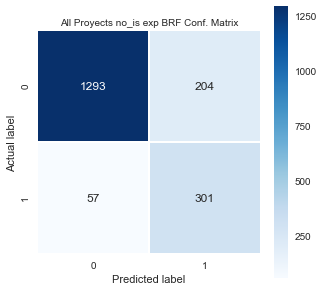

AUC Score: 0.9286244742744334


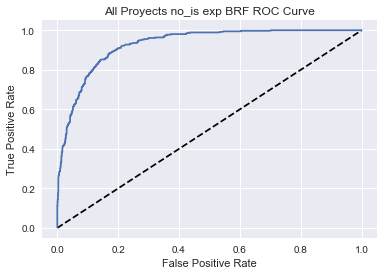

In [82]:
MODEL = 'BRF'
readme['model'][MODEL] = dict()
to_profit_curve[MODEL] = dict()

param_grid = {
    "max_depth": randint(1,30),
    "max_features":randint(1,40),
    "min_samples_leaf": randint(1,20),
    "criterion": ["gini", "entropy"],
    "min_samples_split": randint(2,20),
    "n_estimators":[20,30,40,50,60,70,80,90,100],
    "bootstrap": [True, False],
}

param_dist = {
    "max_depth": range(1,20),
    "max_features":range(1,30),
    "min_samples_leaf": range(1,10),
    "criterion": ["gini", "entropy"]
}

randomForest = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)

# Stratified
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# RandomSearch
random_brf = RandomizedSearchCV(randomForest, param_dist, cv=kf, n_jobs=N_JOBS,  random_state=RANDOM_STATE)

to_profit_curve[MODEL]['model'] = random_brf
# Grid Search
# randomForest_cv = GridSearchCV(randomForest, param_grid, cv=kf, n_jobs=-1)

# Train
random_brf.fit(X, y)

print("Best Params: ", random_brf.best_params_)
print('Best Estimator: ', random_brf.best_estimator_)

best_brf = random_brf.best_estimator_
# Make predictions

score = best_brf.score(X_test, y_test)
print("Accuracy: ", score)

grid_results(random_brf)


,importance,labels
8,0.228299,nro_cot_depto
16,0.178103,San Andres Del Valle
23,0.070720,actividad_Profesional
1,0.047223,is_presencial
13,0.037503,is_recontacto


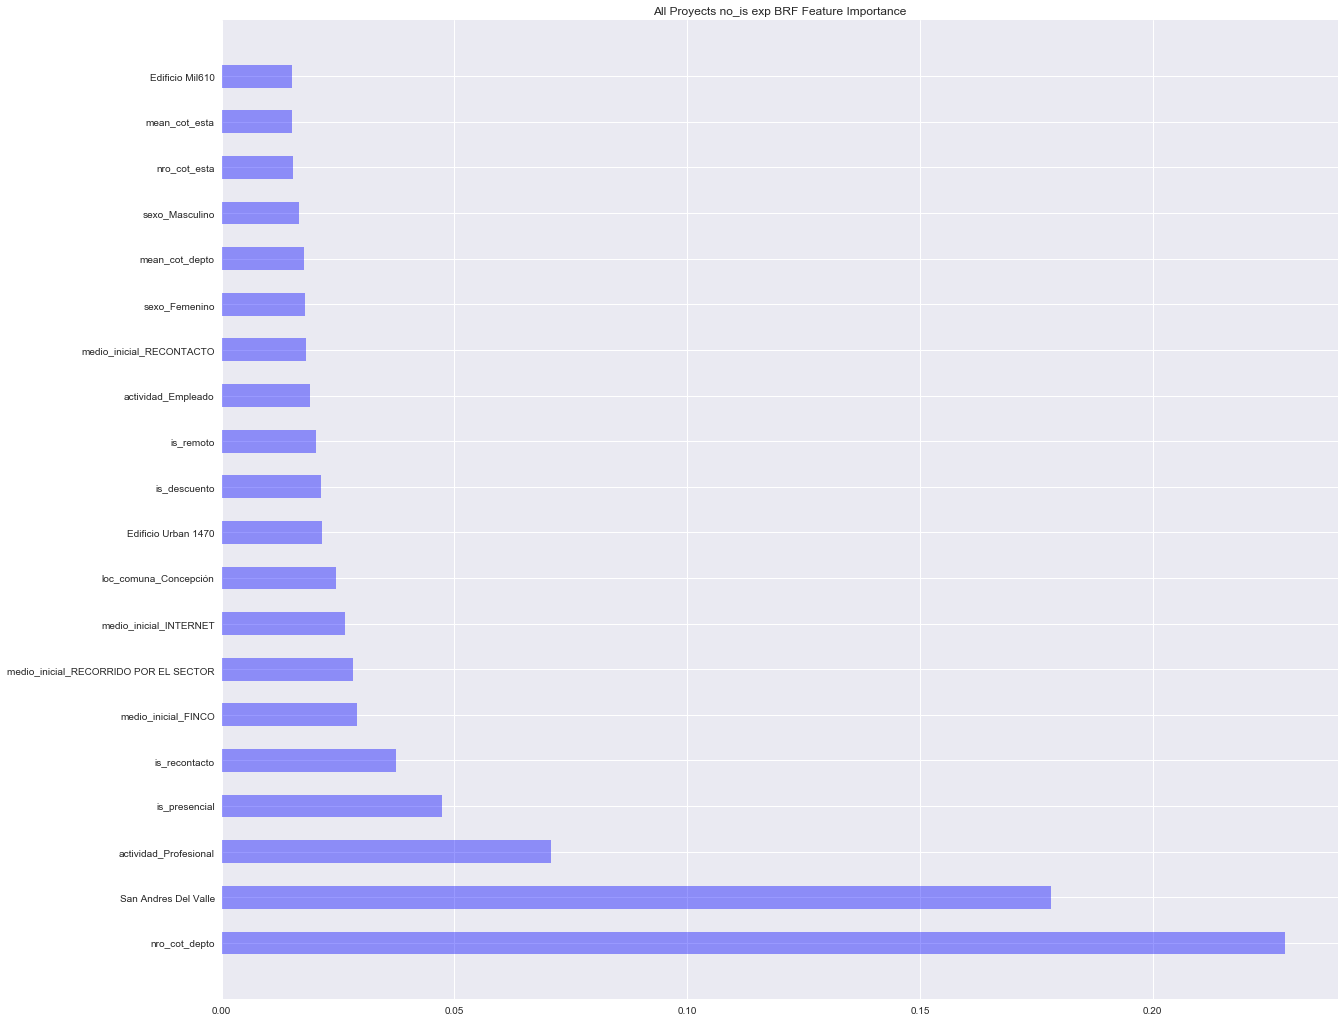

In [38]:
plot_importance_graph(random_brf)

In [83]:
y_brf_probs = best_brf.predict_proba(X_test)

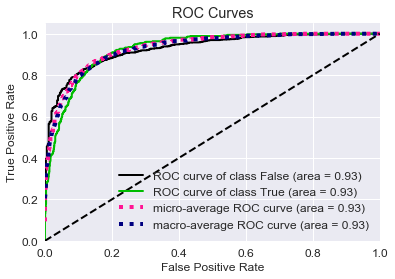

In [84]:
skplt.metrics.plot_roc(y_test, y_brf_probs)

<Figure size 432x288 with 0 Axes>

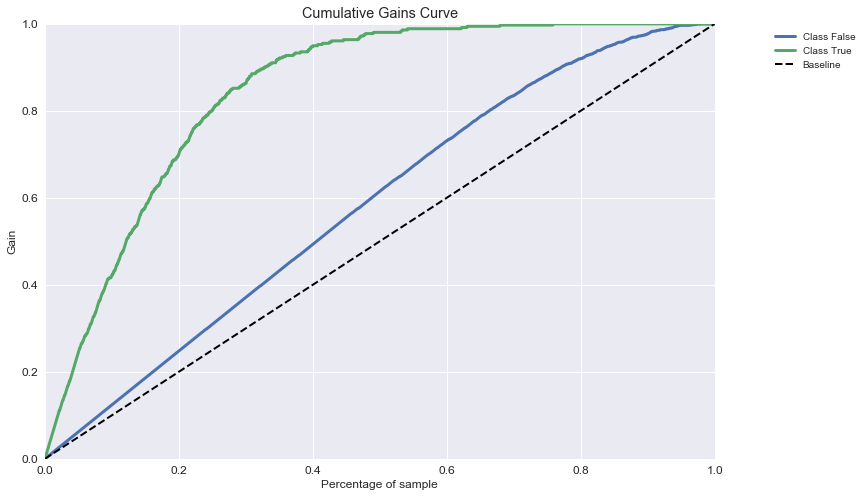

In [85]:
# import scikitplot as skplt

fig = plt.figure()
ax = plt.subplot(skplt.metrics.plot_cumulative_gain(y_test, y_brf_probs, figsize=(12,8)))
plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
plt.savefig('..\\results\\model_results\\{}\\{}_cum_gain.png'.format(DS_NAME, MODEL), bbox_inches = 'tight', dpi=300)
plt.show()


In [ ]:
# fig = plt.figure()
# ax = plt.subplot(skplt.metrics.plot_lift_curve(y_test, brf_probs, figsize=(12,8)))
# plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
# plt.savefig('..\\results\\model_results\\{}\\{}_lift.png'.format(DS_NAME, MODEL), bbox_inches = 'tight', dpi=300)
# plt.show()

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

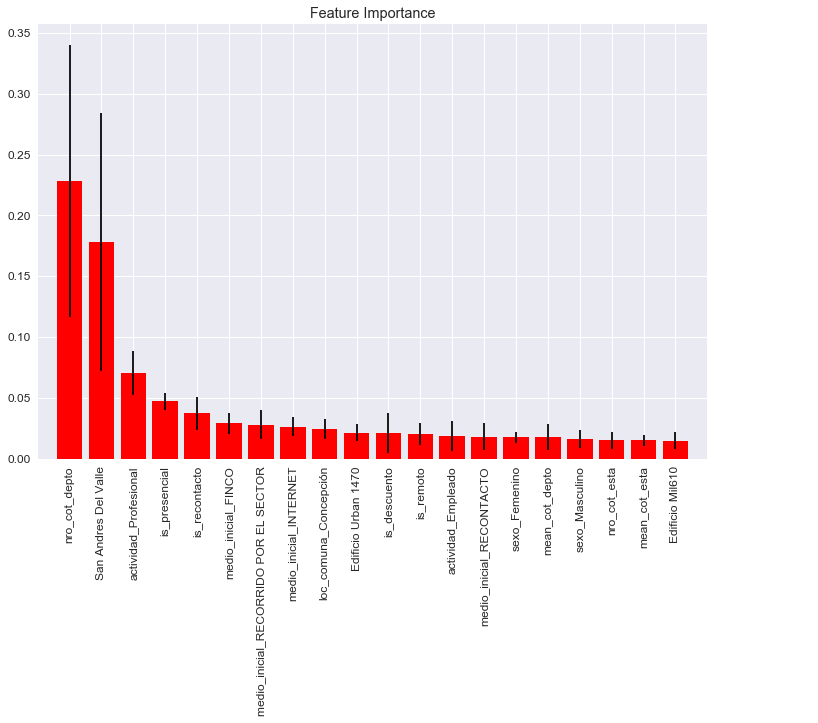

In [41]:
fig = plt.figure()
ax = plt.subplot(skplt.estimators.plot_feature_importances(
    best_brf, feature_names=personas.columns, x_tick_rotation=90, figsize=(12,8)))
plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
plt.savefig('..\\results\\model_results\\{}\\{}_f_importance.png'.format(DS_NAME, MODEL), bbox_inches = 'tight', dpi=300)
plt.show()


In [ ]:

# fig = plt.figure()
# ax = plt.subplot(skplt.metrics.plot_precision_recall(y_test, brf_probs, figsize=(12,8)))
# plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
# plt.savefig('..\\results\\model_results\\{}\\{}_precition_recall.png'.format(DS_NAME, MODEL), bbox_inches = 'tight', dpi=300)
# plt.show()

In [ ]:
# fig = plt.figure()
# ax = plt.subplot(skplt.metrics.plot_ks_statistic(y_test, brf_probs, figsize=(12,8)))
# plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
# plt.savefig('..\\results\\model_results\\{}\\{}_ks_sta.png'.format(DS_NAME, MODEL), bbox_inches = 'tight', dpi=300)
# plt.show()

In [ ]:
from sklearn.model_selection import cross_val_predict
predictions = cross_val_predict(bdt_clf, X, y)

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)
plt.show()

rf.fit(X_train, y_train)
y_probas = rf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()

In [73]:
#train
explainer = shap.KernelExplainer(best_brf.predict_proba, X_train[:20])
#test
shap_values = explainer.shap_values(X_test[:20])



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

  5%|████▏                                                                              | 1/20 [00:00<00:11,  1.63it/s]

 10%|████████▎                                                                          | 2/20 [00:01<00:10,  1.66it/s]

 15%|████████████▍                                                                      | 3/20 [00:01<00:10,  1.66it/s]

 20%|████████████████▌                                                                  | 4/20 [00:02<00:09,  1.66it/s]

 25%|████████████████████▊                                                              | 5/20 [00:03<00:09,  1.65it/s]

 30%|████████████████████████▉                                                          | 6/20 [00:03<00:08,  1.65it/s]

 35%|█████████████████████████████                                                      | 7/20 [00:04<00:07,  1.66it/s]

 40%|█████████████████████████

In [55]:
# visualize the first prediction's explanation
# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

In [57]:
# explain all the predictions in the test set
# plot the SHAP values for the Setosa output of all instances
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, link="logit")

In [86]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

AssertionError: The shap_values arg looks looks multi output, try shap_values[i].

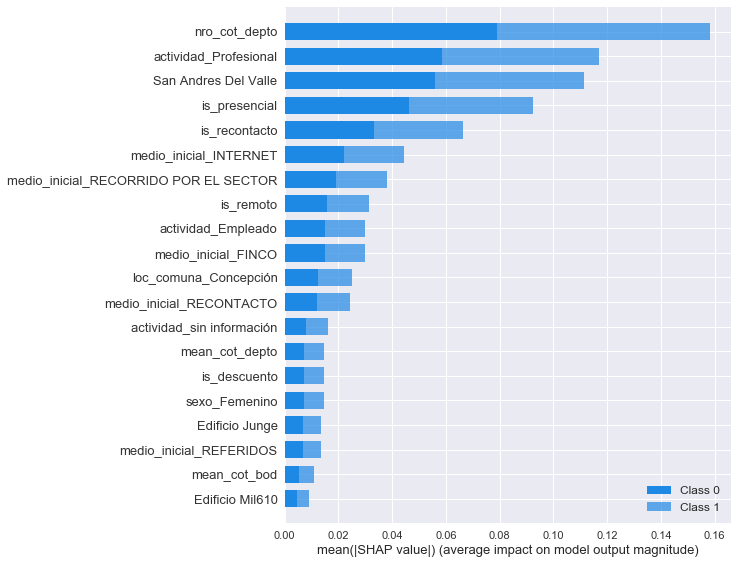

In [87]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

In [88]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("San Andres Del Valle", shap_values, X)

AttributeError: 'list' object has no attribute 'shape'

# XGBOOST

In [89]:
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
# load data
# fit model no training data
model = XGBClassifier()
model.fit(X, y)
# plot feature importance

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] colsample_bytree=0.5, max_depth=2, n_estimators=1000, reg_alpha=0.03, subsample=0.6 
[CV]  colsample_bytree=0.5, max_depth=2, n_estimators=1000, reg_alpha=0.03, subsample=0.6, total=   2.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV] colsample_bytree=0.5, max_depth=2, n_estimators=1000, reg_alpha=0.03, subsample=0.6 
[CV]  colsample_bytree=0.5, max_depth=2, n_estimators=1000, reg_alpha=0.03, subsample=0.6, total=   2.8s
[CV] colsample_bytree=0.5, max_depth=2, n_estimators=1000, reg_alpha=0.03, subsample=0.6 
[CV]  colsample_bytree=0.5, max_depth=2, n_estimators=1000, reg_alpha=0.03, subsample=0.6, total=   2.6s
[CV] colsample_bytree=0.5, max_depth=2, n_estimators=1000, reg_alpha=0.03, subsample=0.6 
[CV]  colsample_bytree=0.5, max_depth=2, n_estimators=1000, reg_alpha=0.03, subsample=0.6, total=   2.7s
[CV] colsample_bytree=0.5, max_depth=2, n_estimators=1000, reg_alpha=0.03, subsample=0.6 
[CV]  colsample_bytree=0.5, max_depth=2, n_estimators=1000, reg_alpha=0.03, subsample=0.6, total=   2.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.5s finished


Best score is -0.33456651209172855

[[1450   47]
 [ 173  185]]
             precision    recall  f1-score   support

      False       0.89      0.97      0.93      1497
       True       0.80      0.52      0.63       358

avg / total       0.87      0.88      0.87      1855



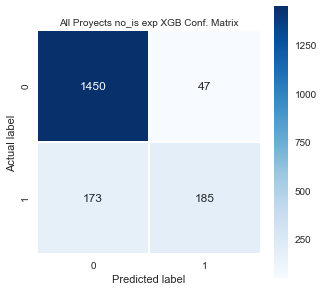

AUC Score: 0.9075478704149453


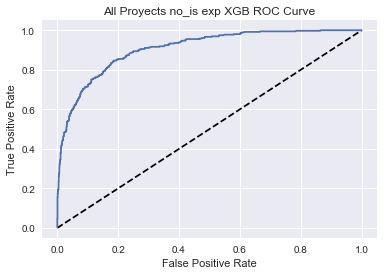

In [90]:
MODEL = 'XGB'
readme['model'][MODEL] = dict()

params={
    'max_depth': [2], #[3,4,5,6,7,8,9], # 5 is good but takes too long in kaggle env
    'subsample': [0.6], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree': [0.5], #[0.5,0.6,0.7,0.8],
    'n_estimators': [1000], #[1000,2000,3000]
    'reg_alpha': [0.03] #[0.01, 0.02, 0.03, 0.04]
}

xgb_clf = XGBClassifier(missing=9999999999, random_state=RANDOM_STATE)
grid_xgb = GridSearchCV(xgb_clf, params, cv=5, scoring="log_loss", n_jobs=1, verbose=2)

grid_xgb.fit(X, y)

grid_results(grid_xgb)

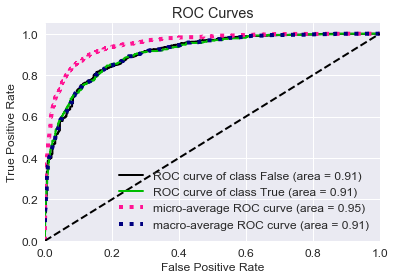

In [91]:
y_probas = grid_xgb.best_estimator_.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()

In [92]:
# use feature importance for feature selection
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = XGBClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 86.90%
Thresh=0.000, n=58, Accuracy: 85.34%
Thresh=0.000, n=58, Accuracy: 85.34%
Thresh=0.000, n=58, Accuracy: 85.34%
Thresh=0.000, n=58, Accuracy: 85.34%
Thresh=0.000, n=58, Accuracy: 85.34%
Thresh=0.000, n=58, Accuracy: 85.34%
Thresh=0.000, n=58, Accuracy: 85.34%
Thresh=0.000, n=58, Accuracy: 85.34%
Thresh=0.000, n=58, Accuracy: 85.34%
Thresh=0.000, n=58, Accuracy: 85.34%
Thresh=0.000, n=58, Accuracy: 85.34%
Thresh=0.000, n=58, Accuracy: 85.34%
Thresh=0.000, n=58, Accuracy: 85.34%
Thresh=0.000, n=58, Accuracy: 85.34%
Thresh=0.000, n=58, Accuracy: 85.34%
Thresh=0.000, n=58, Accuracy: 85.34%
Thresh=0.000, n=58, Accuracy: 85.34%
Thresh=0.000, n=58, Accuracy: 85.34%
Thresh=0.000, n=58, Accuracy: 85.34%
Thresh=0.002, n=39, Accuracy: 85.55%
Thresh=0.002, n=39, Accuracy: 85.55%
Thresh=0.002, n=39, Accuracy: 85.55%
Thresh=0.003, n=36, Accuracy: 85.61%
Thresh=0.006, n=35, Accuracy: 85.61%
Thresh=0.006, n=35, Accuracy: 85.61%
Thresh=0.006, n=35, Accuracy: 85.61%
Thresh=0.006, n=35, A

In [93]:
# import matplotlib.pyplot as plt
# import numpy as np

# f, axarr = plt.subplots(3, 1, figsize=(20,45))
# plot_importance(model, importance_type='weight', ax=axarr[0])
# plot_importance(model, importance_type='cover', ax=axarr[1])
# plot_importance(model, importance_type='gain', ax=axarr[2])
# plt.show()

In [94]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
# X,y = shap.datasets.boston()
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

In [95]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [96]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [97]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


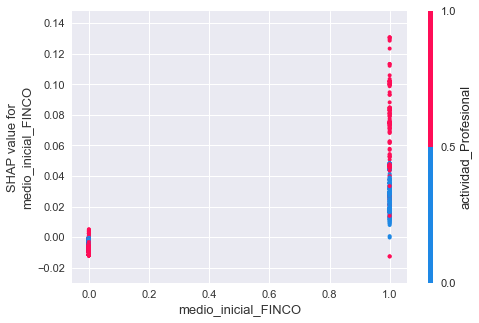

In [71]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("medio_inicial_FINCO", shap_values, X)

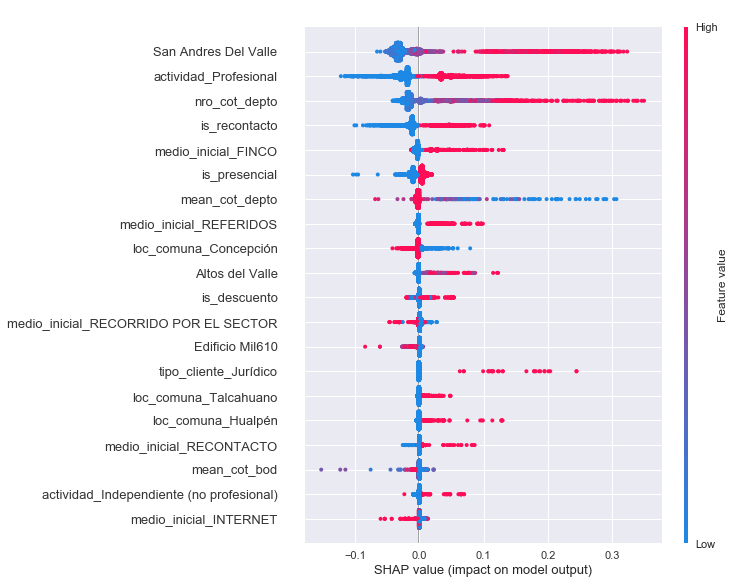

In [68]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

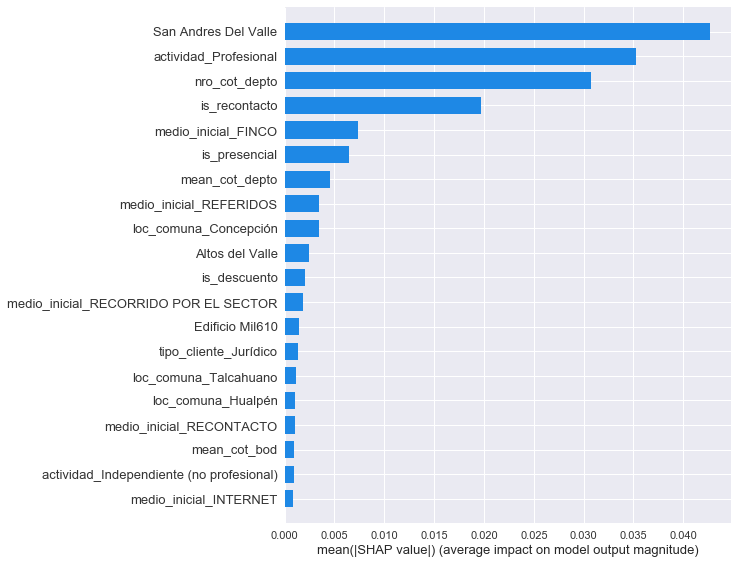

In [69]:
shap.summary_plot(shap_values, X, plot_type="bar")